## Part 1: Street Network with OSMnx

### 1 Load the geometry for the region being analyzed


In [11]:
# The usual imports
import altair as alt
import geopandas as gpd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Show all columns in dataframes
pd.options.display.max_columns = 999

# Hide warnings due to issue in shapely package 
# See: https://github.com/shapely/shapely/issues/1345
np.seterr(invalid="ignore");
import osmnx as ox

NYC = gpd.read_file("new-york-city-boroughs.geojson")
NYC_M = NYC[NYC["name"] == "Manhattan"]

NYC_M

name  cartodb_id                       created_at  \
3  Manhattan           4 2013-03-09 02:42:03.692000+00:00   

                        updated_at  \
3 2013-03-09 02:42:03.989000+00:00   

                                            geometry  
3  MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...

### 2 Get the street network graph


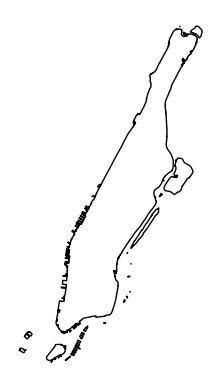

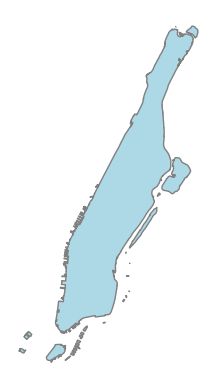

In [27]:
# Project it to Web Mercator first and plot
ax = NYC_M.to_crs(epsg=4326).plot(facecolor="none", edgecolor="black")
ax.set_axis_off()


### 3 Convert your network graph edges to a GeoDataFrame

                                                 osmid               name  \
u        v        key                                                       
42421728 42435337 0                          195743153  Central Park West   
         42421731 0    [420625565, 420625573, 5668966]  West 106th Street   
         42432736 0           [1271523197, 1271523198]  Central Park West   
42421731 42437916 0                            5671485   Manhattan Avenue   
         42432737 0                          195743186   Manhattan Avenue   

                           highway maxspeed  oneway reversed   length  \
u        v        key                                                   
42421728 42435337 0      secondary   25 mph   False     True   85.345   
         42421731 0      secondary      NaN   False    False  138.033   
         42432736 0      secondary   25 mph   False    False   86.275   
42421731 42437916 0    residential      NaN   False     True   86.149   
         42432737 0   

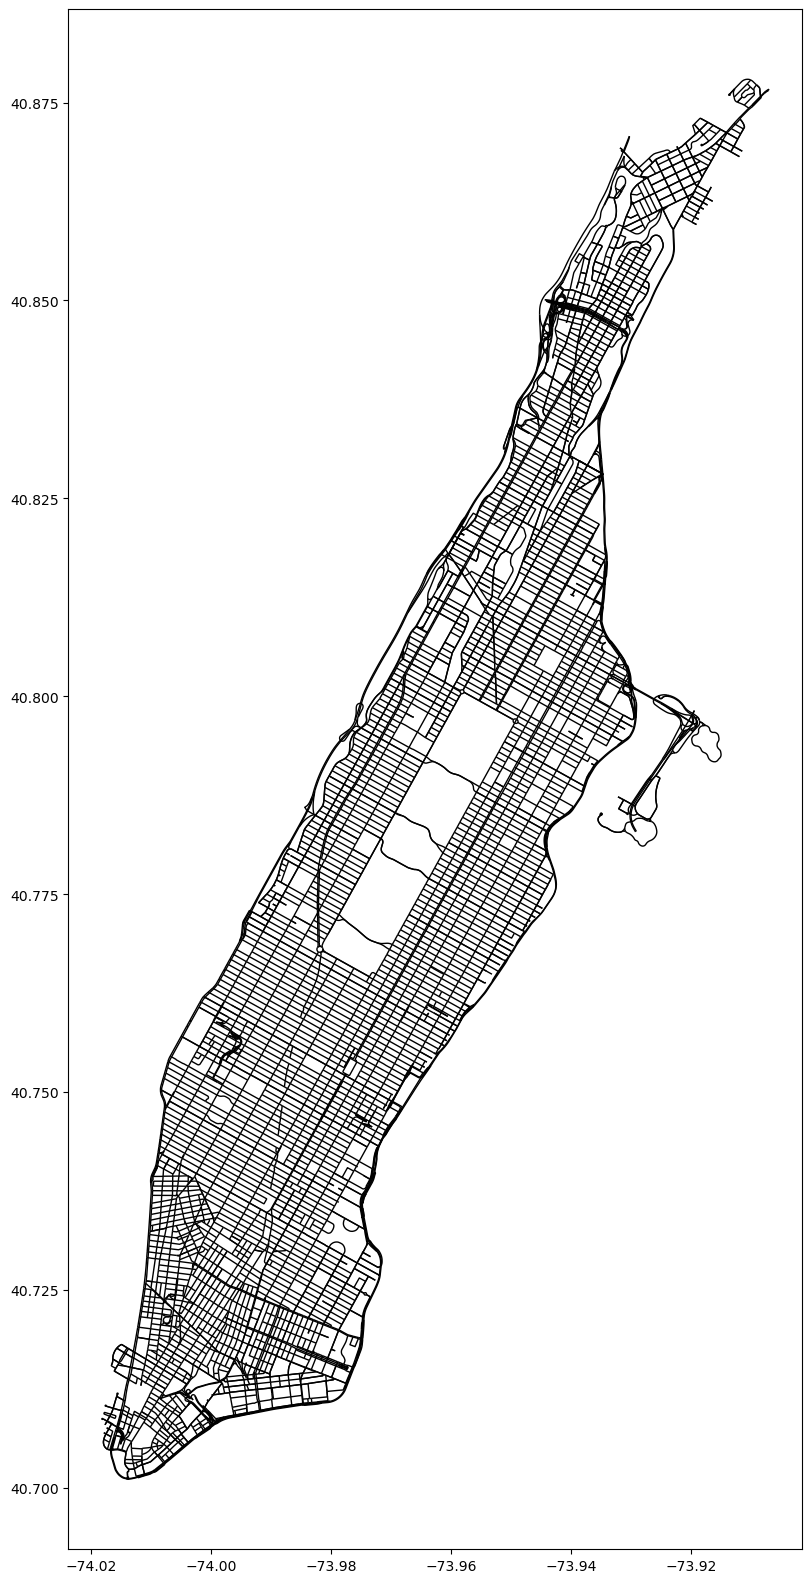

In [28]:
# Define your polygon boundary (replace with your actual polygon)
# For example, if you have a GeoDataFrame with your area boundary:
polygon = NYC_M.unary_union  

# Create a street network graph
G = ox.graph_from_polygon(polygon, network_type='drive')

# Convert graph edges to a GeoDataFrame
edges_gdf = ox.graph_to_gdfs(G, nodes=False, edges=True)

# Display the first few rows of the GeoDataFrame
print(edges_gdf.head())

# Plot the edges GeoDataFrame
fig, ax = plt.subplots(figsize=(20, 20))
edges_gdf.plot(ax=ax, linewidth=1, edgecolor='black')
plt.show()

### 4 Load Crash Data

In [38]:
# Load data into a pandas DataFrame
data = pd.read_csv("Motor_Vehicle_Collisions_Crashes.csv")


In [39]:
data

CRASH DATE CRASH TIME    BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
0      05/01/2021      13:30  MANHATTAN   10029.0  40.796300 -73.938290   
1      05/01/2021      17:50  MANHATTAN   10012.0  40.720936 -73.993805   
2      05/01/2021      13:30  MANHATTAN   10128.0  40.780693 -73.946600   
3      05/01/2021       9:40  MANHATTAN   10026.0  40.800537 -73.948360   
4      05/01/2021      23:03  MANHATTAN   10009.0  40.726864 -73.979910   
...           ...        ...        ...       ...        ...        ...   
32364  12/31/2023      23:18  MANHATTAN   10030.0  40.819670 -73.944240   
32365  12/31/2023      18:03  MANHATTAN   10039.0  40.824130 -73.940980   
32366  12/31/2023      14:00  MANHATTAN   10028.0  40.777890 -73.955890   
32367  12/31/2023      21:34  MANHATTAN   10033.0  40.849308 -73.931920   
32368  12/31/2023       0:38  MANHATTAN   10006.0  40.709496 -74.013900   

                      LOCATION   ON STREET NAME  CROSS STREET NAME  \
0         (40.7963, -73.93829)  EAST 115 STREET           2 AVENUE   
1      (40.720936, -73.993805)           BOWERY      SPRING STREET   
2        (40.780693, -73.9466)   EAST 92 STREET           1 AVENUE   
3       (40.800537, -73.94836)              NaN                NaN   
4       (40.726864, -73.97991)         AVENUE B     EAST 10 STREET   
...                        ...              ...                ...   
32364    (40.81967, -73.94424)         8 AVENUE    WEST 140 STREET   
32365    (40.82413, -73.94098)         8 AVENUE    WEST 147 STREET   
32366    (40.77789, -73.95589)              NaN                NaN   
32367   (40.849308, -73.93192)  WEST 182 STREET     AUDUBON AVENUE   
32368    (40.709496, -74.0139)    ALBANY STREET  WASHINGTON STREET   

                 OFF STREET NAME  NUMBER OF PERSONS INJURED  \
0                            NaN                          0   
1                            NaN                          1   
2                            NaN                          0   
3      40        WEST 115 STREET                          0   
4                            NaN                          1   
...                          ...                        ...   
32364                        NaN                          0   
32365                        NaN                          1   
32366   160       EAST 84 STREET                          0   
32367                        NaN                          0   
32368                        NaN                          0   

       NUMBER OF PERSONS KILLED  NUMBER OF PEDESTRIANS INJURED  \
0                             0                              0   
1                             0                              0   
2                             0                              0   
3                             0                              0   
4                             0                              0   
...                         ...                            ...   
32364                         0                              0   
32365                         0                              1   
32366                         0                              0   
32367                         0                              0   
32368                         0                              0   

       NUMBER OF PEDESTRIANS KILLED  NUMBER OF CYCLIST INJURED  \
0                                 0                          0   
1                                 0                          0   
2                                 0                          0   
3                                 0                          0   
4                                 0                          1   
...                             ...                        ...   
32364                             0                          0   
32365                             0                          0   
32366                             0                          0   
32367                             0                    

### 5 Convert the crash data to a GeoDataFrame

In [44]:
from shapely.geometry import Point

# Check if the necessary columns exist
if 'LATITUDE' in data.columns and 'LONGITUDE' in data.columns:
    # Create a geometry column using the DEC_LAT and DEC_LONG columns
    geometry = [Point(xy) for xy in zip(data['LONGITUDE'], data['LATITUDE'])]
    
    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(data, geometry=geometry)

    # Set the coordinate reference system (CRS) to WGS 84 (EPSG:4326)
    gdf.set_crs(epsg=4326, inplace=True)

    # Display the first few rows of the GeoDataFrame
    print(gdf.head())
else:
    print("The DataFrame does not contain 'DEC_LAT' and 'DEC_LONG' columns.")

   CRASH DATE CRASH TIME    BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
0  05/01/2021      13:30  MANHATTAN   10029.0  40.796300 -73.938290   
1  05/01/2021      17:50  MANHATTAN   10012.0  40.720936 -73.993805   
2  05/01/2021      13:30  MANHATTAN   10128.0  40.780693 -73.946600   
3  05/01/2021       9:40  MANHATTAN   10026.0  40.800537 -73.948360   
4  05/01/2021      23:03  MANHATTAN   10009.0  40.726864 -73.979910   

                  LOCATION   ON STREET NAME CROSS STREET NAME  \
0     (40.7963, -73.93829)  EAST 115 STREET          2 AVENUE   
1  (40.720936, -73.993805)           BOWERY     SPRING STREET   
2    (40.780693, -73.9466)   EAST 92 STREET          1 AVENUE   
3   (40.800537, -73.94836)              NaN               NaN   
4   (40.726864, -73.97991)         AVENUE B    EAST 10 STREET   

             OFF STREET NAME  NUMBER OF PERSONS INJURED  \
0                        NaN                          0   
1                        NaN                          1   
2    

### 6 Trim the crash data to Center City

In [45]:
# Assuming edges_gdf is your GeoDataFrame from part 1.3
manhattan_boundary = edges_gdf.geometry.unary_union.convex_hull

# Filter the crash GeoDataFrame to only include crashes within the boundary
manhattan_crashes = gdf[gdf.geometry.within(manhattan_boundary)]

# Display the number of crashes within the Center City boundary
print(f"Number of crashes within manhattan: {len(manhattan_crashes)}")

# Display the first few rows of the filtered GeoDataFrame
manhattan_crashes.head()

Number of crashes within manhattan: 31042


CRASH DATE CRASH TIME    BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
0  05/01/2021      13:30  MANHATTAN   10029.0  40.796300 -73.938290   
1  05/01/2021      17:50  MANHATTAN   10012.0  40.720936 -73.993805   
2  05/01/2021      13:30  MANHATTAN   10128.0  40.780693 -73.946600   
3  05/01/2021       9:40  MANHATTAN   10026.0  40.800537 -73.948360   
4  05/01/2021      23:03  MANHATTAN   10009.0  40.726864 -73.979910   

                  LOCATION   ON STREET NAME CROSS STREET NAME  \
0     (40.7963, -73.93829)  EAST 115 STREET          2 AVENUE   
1  (40.720936, -73.993805)           BOWERY     SPRING STREET   
2    (40.780693, -73.9466)   EAST 92 STREET          1 AVENUE   
3   (40.800537, -73.94836)              NaN               NaN   
4   (40.726864, -73.97991)         AVENUE B    EAST 10 STREET   

             OFF STREET NAME  NUMBER OF PERSONS INJURED  \
0                        NaN                          0   
1                        NaN                          1   
2                        NaN                          0   
3  40        WEST 115 STREET                          0   
4                        NaN                          1   

   NUMBER OF PERSONS KILLED  NUMBER OF PEDESTRIANS INJURED  \
0                         0                              0   
1                         0                              0   
2                         0                              0   
3                         0                              0   
4                         0                              0   

   NUMBER OF PEDESTRIANS KILLED  NUMBER OF CYCLIST INJURED  \
0                             0                          0   
1                             0                          0   
2                             0                          0   
3                             0                          0   
4                             0                          1   

   NUMBER OF CYCLIST KILLED  NUMBER OF MOTORIST INJURED  \
0                         0                           0   
1                         0                           1   
2                         0                           0   
3                         0                           0   
4                         0                           0   

   NUMBER OF MOTORIST KILLED   CONTRIBUTING FACTOR VEHICLE 1  \
0                          0  Passing or Lane Usage Improper   
1                          0  Driver Inattention/Distraction   
2                          0  Driver Inattention/Distraction   
3                          0                Backing Unsafely   
4                          0  Driver Inattention/Distraction   

    CONTRIBUTING FACTOR VEHICLE 2 CONTRIBUTING FACTOR VEHICLE 3  \
0                     Unspecified                           NaN   
1                     Unspecified                           NaN   
2                     Unspecified                           NaN   
3                     Unspecified                           NaN   
4  Driver Inattention/Distraction                           NaN   

  CONTRIBUTING FACTOR VEHICLE 4 CONTRIBUTING FACTOR VEHICLE 5  COLLISION_ID  \
0                           NaN                           NaN       4412937   
1                           NaN                           NaN       4412445   
2                           NaN                           NaN       4414390   
3                           NaN                           NaN       4417017   
4                           NaN                           NaN       4412243   

                   VEHICLE TYPE CODE 1 VEHICLE TYPE CODE 2  \
0                                  Bus               Sedan   
1                                Sedan               Sedan   
2                            AMBULANCE               Sedan   
3  Station Wagon/Sport Utility Vehicle                 NaN   
4                                 Bike                 NaN   

  VEHICLE TYPE CODE 3 VEHICLE TYPE CODE 4 VEHICLE TYPE CODE 5  \
0                 NaN       

### 7 Re-project our data into an approriate CRS2263

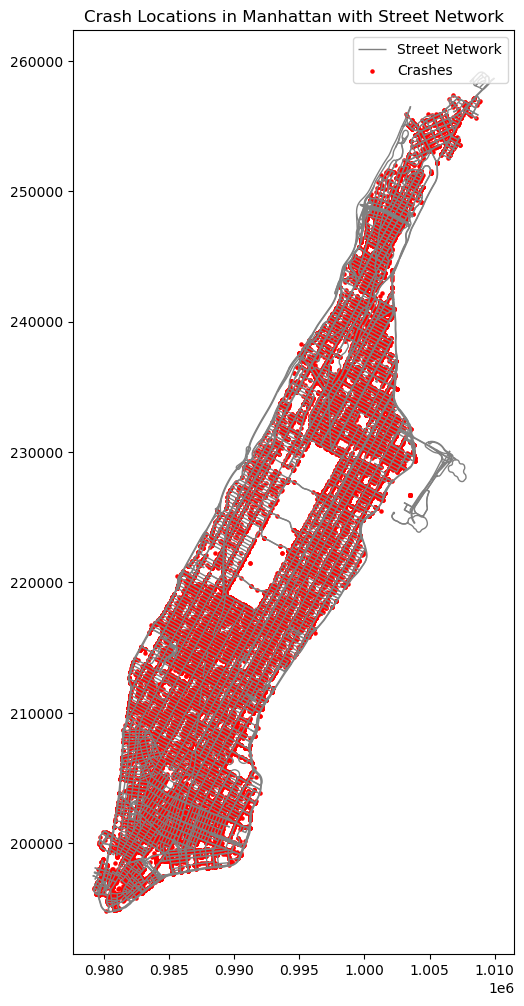

In [46]:
import osmnx as ox

# Assuming G is your graph object
# Project the graph to the Philadelphia state plane CRS (EPSG:2272)
G_projected = ox.project_graph(G, to_crs='EPSG:2263')

# Project the crash GeoDataFrame to the Philadelphia state plane CRS (EPSG:2272)
manhattan_crashes_projected = manhattan_crashes.to_crs(epsg=2263)

# Display the first few rows of the projected GeoDataFrame
manhattan_crashes_projected.head()

# Create a plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the street network
edges_gdf_projected = ox.graph_to_gdfs(G_projected, nodes=False)
edges_gdf_projected.plot(ax=ax, linewidth=1, edgecolor='gray', label='Street Network')

# Plot the crash locations
manhattan_crashes_projected.plot(ax=ax, marker='o', color='red', markersize=5, label='Crashes')

# Add a title and legend
plt.title('Crash Locations in Manhattan with Street Network')
plt.legend()

# Show the plot
plt.show()

### 1.8 Find the nearest edge for each crash
See: ox.distance.nearest_edges(). It takes three arguments:

the network graph
the longitude of your crash data (the x attribute of the geometry column)
the latitude of your crash data (the y attribute of the geometry column)
You will get a numpy array with 3 columns that represent (u, v, key) where each u and v are the node IDs that the edge links together. We will ignore the key value for our analysis.

In [47]:
# Extract x and y coordinates from the geometry column
crash_x = manhattan_crashes_projected.geometry.x
crash_y = manhattan_crashes_projected.geometry.y

# Find the nearest edges for each crash
nearest_edges = ox.distance.nearest_edges(G_projected, crash_x, crash_y)

# Convert the result to a numpy array
nearest_edges_array = np.array(nearest_edges)

# Display the first few results
print(nearest_edges_array[:5])

# Extract only the u and v columns, ignoring the key
nearest_edges_uv = nearest_edges_array[:, :2]

# Display the first few u, v pairs
print(nearest_edges_uv[:5])

[[4207962275   42443081          0]
 [  42437605 1773076509          0]
 [  42443048   42448745          0]
 [  42435387   42446772          0]
 [  42430924   42430938          0]]
[[4207962275   42443081]
 [  42437605 1773076509]
 [  42443048   42448745]
 [  42435387   42446772]
 [  42430924   42430938]]


### 1.9 Calculate the total number of crashes per street

In [48]:
# Create a DataFrame from the nearest edges data
edges_df = pd.DataFrame(nearest_edges_array, columns=['u', 'v', 'key'])

# Group by 'u' and 'v' and calculate the size of each group
crash_counts = edges_df.groupby(['u', 'v']).size().reset_index(name='crash_count')

# Display the resulting DataFrame
crash_counts

u            v  crash_count
0        42421728     42432736            2
1        42421731     42437916            1
2        42421737     42437917            2
3        42421741     42432756            1
4        42421751     42421749            1
...           ...          ...          ...
5796  12162436970     42455357            2
5797  12181309686   4597668039            5
5798  12299314857  12299314860            1
5799  12299314860     42438476            3
5800  12374690312     42433537            1

[5801 rows x 3 columns]

### 1.10 Merge your edges GeoDataFrame and crash count DataFrame

In [49]:
# Convert the projected graph to a GeoDataFrame for edges
edges_gdf_projected = ox.graph_to_gdfs(G_projected, nodes=False)

# Merge the edges GeoDataFrame with the crash counts DataFrame
merged_df = edges_gdf_projected.merge(crash_counts, on=['u', 'v'], how='left')

# Fill missing crash count values with zero
merged_df['crash_count'] = merged_df['crash_count'].fillna(0)

# Display the first few rows of the merged DataFrame
merged_df

# Filter out rows where crash_count is 0.0
filtered_df = merged_df[merged_df['crash_count'] > 0.0]

# Display the first few rows of the filtered DataFrame
filtered_df

u           v  \
2        42421728    42432736   
3        42435337    42437916   
6        42421731    42437916   
11       42432736    42435341   
13       42437916    42437917   
...           ...         ...   
9864   7802856372  7802856349   
9865   7802856372  7802856356   
9867   8288270047   246580982   
9869   8840333851    42453952   
9878  11942111842    42434962   

                                                  osmid               name  \
2                              [1271523197, 1271523198]  Central Park West   
3                                               5670640  West 105th Street   
6                                               5671485   Manhattan Avenue   
11                                           1271523197  Central Park West   
13                                              5670640  West 105th Street   
...                                                 ...                ...   
9864                                          661227257  Central Park West   
9865                           [1271523171, 1271523172]  Central Park West   
9867                                            5671698   West 16th Street   
9869                                            5672377      Church Street   
9878  [658488325, 658499796, 658499797, 420872214, 6...                NaN   

            highway maxspeed  oneway reversed   length  \
2         secondary   25 mph   False    False   86.275   
3       residential   25 mph    True    False  137.996   
6       residential      NaN   False     True   86.149   
11        secondary   25 mph   False    False   80.116   
13      residential   25 mph    True    False  135.012   
...             ...      ...     ...      ...      ...   
9864      secondary   25 mph   False     True   80.457   
9865      secondary   25 mph   False    False   79.496   
9867    residential   25 mph    True    False   21.068   
9869      secondary   25 mph    True    False   83.590   
9878  motorway_link      NaN    True    False  290.747   

                                               geometry      lanes  ref  \
2     LINESTRING (995312.767 230030.016, 995334.152 ...        NaN  NaN   
3     LINESTRING (995176.877 229785.340, 995144.253 ...          1  NaN   
6     LINESTRING (994916.519 230250.770, 994899.394 ...        NaN  NaN   
11    LINESTRING (995450.120 230277.316, 995461.822 ...        NaN  NaN   
13    LINESTRING (994779.437 230003.728, 994751.078 ...          1  NaN   
...                                                 ...        ...  ...   
9864  LINESTRING (990516.812 221373.627, 990505.794 ...          4  NaN   
9865  LINESTRING (990516.812 221373.627, 990527.802 ...          4  NaN   
9867  LINESTRING (981879.246 210378.461, 981886.366 ...          1  NaN   
9869  LINESTRING (981444.123 198698.940, 981458.126 ...          3  NaN   
9878  LINESTRING (991424.925 211158.515, 991364.955 ...  [2, 1, 3]  NaN   

     access bridge tunnel width junction  crash_count  
2       NaN    NaN    NaN   NaN      NaN          2.0  
3       NaN    NaN    NaN   NaN      NaN          1.0  
6       NaN    NaN    NaN   NaN      NaN          1.0  
11      NaN    NaN    NaN   NaN      NaN          2.0  
13      NaN    NaN    NaN   NaN      NaN          8.0  
...     ...    ...    ...   ...      ...          ...  
9864    NaN    NaN    NaN   NaN      NaN          1.0  
9865    NaN    NaN    NaN   NaN      NaN          4.0  
9867    NaN    NaN    NaN   NaN      NaN          6.0  
9869    NaN    NaN    NaN   NaN      NaN          2.0  
9878    NaN    NaN    NaN   NaN      NaN          1.0  

[5805 rows x 18 columns]

### 1.11 Calculate a "Crash Index"

In [50]:
# Step 1: Calculate the crash index
filtered_df['crash_index'] = np.log10(filtered_df['crash_count'] / filtered_df['length'])

# Step 2: Normalize the crash index
min_crash_index = filtered_df['crash_index'].min()
max_crash_index = filtered_df['crash_index'].max()

# Normalize the crash_index to a 0-1 scale
filtered_df['crash_index_normalized'] = (filtered_df['crash_index'] - min_crash_index) / (max_crash_index - min_crash_index)

filtered_df

C:\Users\willi\miniforge3\envs\musa-550-fall-2023\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\willi\miniforge3\envs\musa-550-fall-2023\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


u           v  \
2        42421728    42432736   
3        42435337    42437916   
6        42421731    42437916   
11       42432736    42435341   
13       42437916    42437917   
...           ...         ...   
9864   7802856372  7802856349   
9865   7802856372  7802856356   
9867   8288270047   246580982   
9869   8840333851    42453952   
9878  11942111842    42434962   

                                                  osmid               name  \
2                              [1271523197, 1271523198]  Central Park West   
3                                               5670640  West 105th Street   
6                                               5671485   Manhattan Avenue   
11                                           1271523197  Central Park West   
13                                              5670640  West 105th Street   
...                                                 ...                ...   
9864                                          661227257  Central Park West   
9865                           [1271523171, 1271523172]  Central Park West   
9867                                            5671698   West 16th Street   
9869                                            5672377      Church Street   
9878  [658488325, 658499796, 658499797, 420872214, 6...                NaN   

            highway maxspeed  oneway reversed   length  \
2         secondary   25 mph   False    False   86.275   
3       residential   25 mph    True    False  137.996   
6       residential      NaN   False     True   86.149   
11        secondary   25 mph   False    False   80.116   
13      residential   25 mph    True    False  135.012   
...             ...      ...     ...      ...      ...   
9864      secondary   25 mph   False     True   80.457   
9865      secondary   25 mph   False    False   79.496   
9867    residential   25 mph    True    False   21.068   
9869      secondary   25 mph    True    False   83.590   
9878  motorway_link      NaN    True    False  290.747   

                                               geometry      lanes  ref  \
2     LINESTRING (995312.767 230030.016, 995334.152 ...        NaN  NaN   
3     LINESTRING (995176.877 229785.340, 995144.253 ...          1  NaN   
6     LINESTRING (994916.519 230250.770, 994899.394 ...        NaN  NaN   
11    LINESTRING (995450.120 230277.316, 995461.822 ...        NaN  NaN   
13    LINESTRING (994779.437 230003.728, 994751.078 ...          1  NaN   
...                                                 ...        ...  ...   
9864  LINESTRING (990516.812 221373.627, 990505.794 ...          4  NaN   
9865  LINESTRING (990516.812 221373.627, 990527.802 ...          4  NaN   
9867  LINESTRING (981879.246 210378.461, 981886.366 ...          1  NaN   
9869  LINESTRING (981444.123 198698.940, 981458.126 ...          3  NaN   
9878  LINESTRING (991424.925 211158.515, 991364.955 ...  [2, 1, 3]  NaN   

     access bridge tunnel width junction  crash_count  crash_index  \
2       NaN    NaN    NaN   NaN      NaN          2.0    -1.634855   
3       NaN    NaN    NaN   NaN      NaN          1.0    -2.139866   
6       NaN    NaN    NaN   NaN      NaN          1.0    -1.935250   
11      NaN    NaN    NaN   NaN      NaN          2.0    -1.602689   
13      NaN    NaN    NaN   NaN      NaN          8.0    -1.227282   
...     ...    ...    ...   ...      ...          ...          ...   
9864    NaN    NaN    NaN   NaN      NaN          1.0    -1.905564   
9865    NaN    NaN    NaN   NaN      NaN          4.0    -1.298285   
9867    NaN    NaN    NaN   NaN      NaN          6.0    -0.545472   
9869    NaN    NaN    NaN   NaN      NaN          2.0    -1.621124   
9878    NaN    NaN    NaN   NaN      NaN          1.0    -2.463515   

      crash_index_normalized  
2                   0.384469  
3                   0.244838  
6                   0.301413  
11                  0.393363  
13                  0.497160  
...                      ...  
9864                0.3096

### 1.12 Plot a histogram of the crash index values


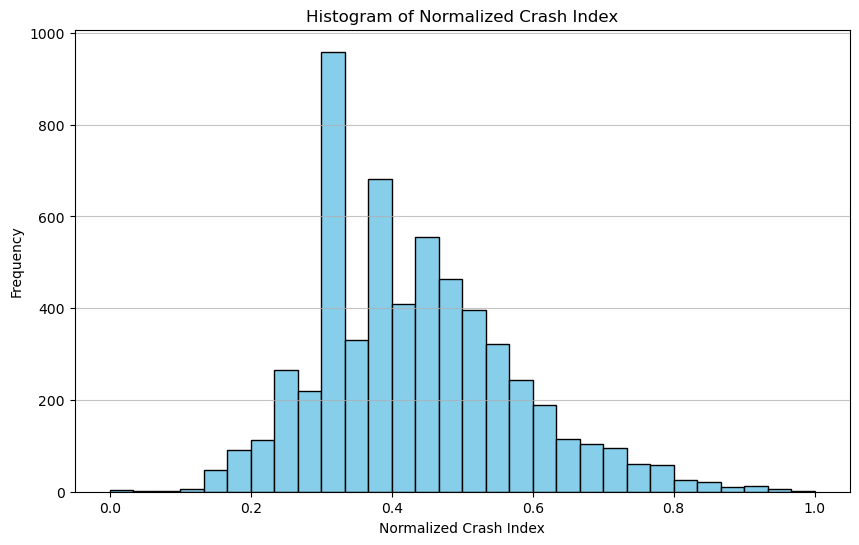

In [52]:
import matplotlib.pyplot as plt

# Assuming filtered_df is already defined and contains 'crash_index_normalized'

# Plot a histogram of the normalized crash index values
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['crash_index_normalized'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Normalized Crash Index')
plt.xlabel('Normalized Crash Index')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Show the plot
plt.show()

### 1.13 Plot an interactive map of the street networks, colored by the crash index


In [102]:
import folium
import geopandas as gpd
import matplotlib.pyplot as plt

# Assuming 'filtered_df' is your GeoDataFrame with the 'crash_index_normalized' column

# Create a base map centered around the Central district with a dark theme
m = folium.Map(location=[40.7826, -73.9656], zoom_start=12, tiles='CartoDB dark_matter')

# Define a function to style the lines based on the crash index
def style_function(feature):
    crash_index = feature['properties']['crash_index_normalized']
    # Use the 'viridis' colormap for a color gradient
    colormap = plt.cm.get_cmap('viridis')
    # Get the RGBA color based on the crash index
    color = colormap(crash_index)  # crash_index should already be normalized [0, 1]
    # Convert RGBA to hex
    color_hex = '#{:02x}{:02x}{:02x}'.format(int(color[0]*255), int(color[1]*255), int(color[2]*255))
    return {
        'color': color_hex,
        'weight': 3 + crash_index * 2,  # Increase line weight for higher crash index
        'opacity': 0.8
    }

# Add the GeoDataFrame to the map
folium.GeoJson(
    filtered_df,
    style_function=style_function,
    tooltip=folium.GeoJsonTooltip(fields=['name', 'crash_index_normalized']),
).add_to(m)


# Display the map
m

C:\Users\willi\AppData\Local\Temp\ipykernel_6436\3546299534.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('viridis')


In [61]:
m.save('mahattan_crash_index_map_dark.html')


C:\Users\willi\AppData\Local\Temp\ipykernel_6436\853944911.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('viridis')


## Part 2: Density Map of Crashes by time of the day

In [97]:
#load large data
dat2 = pd.read_csv("Crash data_large.csv")


In [98]:
# Convert 'CRASH TIME' to datetime format if it's not already in datetime
dat2['CRASH TIME'] = pd.to_datetime(dat2['CRASH TIME'], format='%H:%M')

# Extract the hour from 'CRASH TIME' and create a new column called 'CRASH HOUR'
dat2['CRASH HOUR'] = dat2['CRASH TIME'].dt.hour

dat2

CRASH DATE          CRASH TIME    BOROUGH  ZIP CODE   LATITUDE  \
0       07/01/2012 1900-01-01 09:00:00  MANHATTAN   10022.0  40.757859   
1       07/01/2012 1900-01-01 18:30:00  MANHATTAN   10014.0  40.740942   
2       07/01/2012 1900-01-01 03:58:00  MANHATTAN   10002.0  40.721986   
3       07/01/2012 1900-01-01 23:45:00  MANHATTAN   10016.0  40.741643   
4       07/01/2012 1900-01-01 15:55:00  MANHATTAN   10021.0  40.769750   
...            ...                 ...        ...       ...        ...   
328771  12/03/2024 1900-01-01 04:55:00  MANHATTAN   10010.0  40.742912   
328772  12/03/2024 1900-01-01 19:25:00  MANHATTAN   10065.0  40.762490   
328773  12/03/2024 1900-01-01 13:34:00  MANHATTAN   10030.0  40.821262   
328774  12/03/2024 1900-01-01 19:21:00  MANHATTAN   10029.0  40.798615   
328775  12/03/2024 1900-01-01 02:22:00  MANHATTAN   10035.0  40.805058   

        LONGITUDE                   LOCATION  \
0      -73.975592   (40.7578587, -73.975592)   
1      -74.007481  (40.7409424, -74.0074808)   
2      -73.985515  (40.7219864, -73.9855153)   
3      -73.978167  (40.7416432, -73.9781673)   
4      -73.960602  (40.7697502, -73.9606016)   
...           ...                        ...   
328771 -73.992805    (40.742912, -73.992805)   
328772 -73.962975     (40.76249, -73.962975)   
328773 -73.946075    (40.821262, -73.946075)   
328774 -73.943740     (40.798615, -73.94374)   
328775 -73.939030     (40.805058, -73.93903)   

                          ON STREET NAME                 CROSS STREET NAME  \
0       EAST 50 STREET                    MADISON AVENUE                     
1       WEST 13 STREET                    WASHINGTON STREET                  
2       EAST HOUSTON STREET               NORFOLK STREET                     
3       EAST 29 STREET                    2 AVENUE                           
4       EAST 72 STREET                    3 AVENUE                           
...                                  ...                               ...   
328771                           W 23 ST            AVENUE OF THE AMERICAS   
328772                           E 62 ST                             2 AVE   
328773                          W 141 ST                   ST NICHOLAS AVE   
328774                          E 115 ST                          PARK AVE   
328775                          E 125 ST                          PARK AVE   

       OFF STREET NAME  NUMBER OF PERSONS INJURED  NUMBER OF PERSONS KILLED  \
0                  NaN                        1.0                       0.0   
1                  NaN                        0.0                       0.0   
2                  NaN                        0.0                       0.0   
3                  NaN                        0.0                       0.0   
4                  NaN                        1.0                       0.0   
...                ...                        ...                       ...   
328771             NaN                        0.0                       0.0   
328772             NaN                        0.0                       0.0   
328773             NaN                        1.0                       0.0   
328774             NaN                        0.0                       0.0   
328775             NaN                        0.0                       0.0   

        NUMBER OF PEDESTRIANS INJURED  NUMBER OF PEDESTRIANS KILLED  \
0                                   1                             0   
1                                   0                             0   
2                                   0                             0   
3                                   0                             0   
4                                   1                             0   
...                               ...                           ...   
328771                              0                             0   
328772                              0                             0   
328773           

In [100]:
if 'LATITUDE' in dat2.columns and 'LONGITUDE' in data.columns:
    # Create a geometry column using the DEC_LAT and DEC_LONG columns
    geometry = [Point(xy) for xy in zip(data['LONGITUDE'], data['LATITUDE'])]
    
    # Create a GeoDataFrame
    gdf2 = gpd.GeoDataFrame(data, geometry=geometry)

    # Set the coordinate reference system (CRS) to WGS 84 (EPSG:4326)
    gdf2.set_crs(epsg=4326, inplace=True)

# Filter the crash GeoDataFrame to only include crashes within the boundary
dat2 = gdf[gdf.geometry.within(manhattan_boundary)]

# Display the number of crashes within the Center City boundary
print(f"Number of crashes within manhattan: {len(manhattan_crashes)}")

# Display the first few rows of the filtered GeoDataFrame
manhattan_crashes.head()

   CRASH DATE CRASH TIME    BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
0  05/01/2021      13:30  MANHATTAN   10029.0  40.796300 -73.938290   
1  05/01/2021      17:50  MANHATTAN   10012.0  40.720936 -73.993805   
2  05/01/2021      13:30  MANHATTAN   10128.0  40.780693 -73.946600   
3  05/01/2021       9:40  MANHATTAN   10026.0  40.800537 -73.948360   
4  05/01/2021      23:03  MANHATTAN   10009.0  40.726864 -73.979910   

                  LOCATION   ON STREET NAME CROSS STREET NAME  \
0     (40.7963, -73.93829)  EAST 115 STREET          2 AVENUE   
1  (40.720936, -73.993805)           BOWERY     SPRING STREET   
2    (40.780693, -73.9466)   EAST 92 STREET          1 AVENUE   
3   (40.800537, -73.94836)              NaN               NaN   
4   (40.726864, -73.97991)         AVENUE B    EAST 10 STREET   

             OFF STREET NAME  NUMBER OF PERSONS INJURED  \
0                        NaN                          0   
1                        NaN                          1   
2    

CRASH DATE          CRASH TIME    BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
0  05/01/2021 1900-01-01 13:30:00  MANHATTAN   10029.0  40.796300 -73.938290   
1  05/01/2021 1900-01-01 17:50:00  MANHATTAN   10012.0  40.720936 -73.993805   
2  05/01/2021 1900-01-01 13:30:00  MANHATTAN   10128.0  40.780693 -73.946600   
3  05/01/2021 1900-01-01 09:40:00  MANHATTAN   10026.0  40.800537 -73.948360   
4  05/01/2021 1900-01-01 23:03:00  MANHATTAN   10009.0  40.726864 -73.979910   

                  LOCATION   ON STREET NAME CROSS STREET NAME  \
0     (40.7963, -73.93829)  EAST 115 STREET          2 AVENUE   
1  (40.720936, -73.993805)           BOWERY     SPRING STREET   
2    (40.780693, -73.9466)   EAST 92 STREET          1 AVENUE   
3   (40.800537, -73.94836)              NaN               NaN   
4   (40.726864, -73.97991)         AVENUE B    EAST 10 STREET   

             OFF STREET NAME  NUMBER OF PERSONS INJURED  \
0                        NaN                          0   
1                        NaN                          1   
2                        NaN                          0   
3  40        WEST 115 STREET                          0   
4                        NaN                          1   

   NUMBER OF PERSONS KILLED  NUMBER OF PEDESTRIANS INJURED  \
0                         0                              0   
1                         0                              0   
2                         0                              0   
3                         0                              0   
4                         0                              0   

   NUMBER OF PEDESTRIANS KILLED  NUMBER OF CYCLIST INJURED  \
0                             0                          0   
1                             0                          0   
2                             0                          0   
3                             0                          0   
4                             0                          1   

   NUMBER OF CYCLIST KILLED  NUMBER OF MOTORIST INJURED  \
0                         0                           0   
1                         0                           1   
2                         0                           0   
3                         0                           0   
4                         0                           0   

   NUMBER OF MOTORIST KILLED   CONTRIBUTING FACTOR VEHICLE 1  \
0                          0  Passing or Lane Usage Improper   
1                          0  Driver Inattention/Distraction   
2                          0  Driver Inattention/Distraction   
3                          0                Backing Unsafely   
4                          0  Driver Inattention/Distraction   

    CONTRIBUTING FACTOR VEHICLE 2 CONTRIBUTING FACTOR VEHICLE 3  \
0                     Unspecified                           NaN   
1                     Unspecified                           NaN   
2                     Unspecified                           NaN   
3                     Unspecified                           NaN   
4  Driver Inattention/Distraction                           NaN   

  CONTRIBUTING FACTOR VEHICLE 4 CONTRIBUTING FACTOR VEHICLE 5  COLLISION_ID  \
0                           NaN                           NaN       4412937   
1                           NaN                           NaN       4412445   
2                           NaN                           NaN       4414390   
3                           NaN                           NaN       4417017   
4                           NaN                           NaN       4412243   

                   VEHICLE TYPE CODE 1 VEHICLE TYPE CODE 2  \
0                                  Bus               Sedan   
1                                Sedan               Sedan   
2                            AMBULANCE               Sedan   
3  Station Wagon/Sport Utility Vehicle                 NaN   
4                                 Bike                 NaN   

  VEHICLE TYPE CODE 3 VEHICLE TYPE CODE

In [86]:
from colorcet import fire

import holoviews as hv
import geoviews as gv

In [101]:

plot = dat2.hvplot.points(
    geo=True,  # Enables geographic plotting
    x='LONGITUDE',  # Longitude for x-axis
    y='LATITUDE',  # Latitude for y-axis
    frame_width=800,  # Set frame width
    frame_height=600,  # Set frame height
    cmap=fire,  # Use the Fire colormap
    datashade=True,  # Enable datashading for large datasets
    crs=4326,
    title='Manhattan Crashes'  # Set the plot title
)

# Add a dark background map
bg = gv.tile_sources.CartoDark

# Combine the background map and the plot
bg * plot


:DynamicMap   []
   :Overlay
      .WMTS.I :WMTS   [Longitude,Latitude]
      .RGB.I  :RGB   [LONGITUDE,LATITUDE]   (R,G,B,A)

## Part 3: Density Map of Crashes due to pass/following too closely 

In [66]:
import altair as alt

# Count the occurrences of each contributing factor
factor_counts = manhattan_crashes["CONTRIBUTING FACTOR VEHICLE 1"].value_counts().reset_index()
factor_counts.columns = ["Contributing Factor", "Frequency"]

# Select the top 10 contributing factors
top_10_factors = factor_counts.head(10)

# Create a bar chart using Altair
chart = alt.Chart(top_10_factors).mark_bar().encode(
    x=alt.X("Frequency:Q", title="Frequency"),
    y=alt.Y("Contributing Factor:N", sort='-x', title="Contributing Factor"),
    color=alt.Color("Contributing Factor:N", legend=None),  # Color by factor, no legend
    tooltip=[
        alt.Tooltip("Contributing Factor:N", title="Factor"),
        alt.Tooltip("Frequency:Q", title="Count")
    ]
).properties(
    title="Top 10 Contributing Factors for Vehicle Crashes in Manhattan (2021-2023)",
    width=600,
    height=400
)

# Display the chart
chart

alt.Chart(...)

In [71]:
manhattan_crashes_filtered = manhattan_crashes[
    (manhattan_crashes["CONTRIBUTING FACTOR VEHICLE 1"] == "Passing Too Closely") |
    (manhattan_crashes["CONTRIBUTING FACTOR VEHICLE 1"] == "Following Too Closely")
]

manhattan_crashes_filtered

CRASH DATE CRASH TIME    BOROUGH  ZIP CODE   LATITUDE  LONGITUDE  \
5      05/01/2021       3:01  MANHATTAN   10032.0  40.832886 -73.944020   
20     05/01/2021      13:54  MANHATTAN   10036.0  40.761300 -73.999435   
22     05/01/2021      17:55  MANHATTAN   10029.0  40.799984 -73.944855   
34     05/01/2021       9:45  MANHATTAN   10035.0  40.802753 -73.933580   
46     05/02/2021      12:15  MANHATTAN   10037.0  40.810024 -73.937540   
...           ...        ...        ...       ...        ...        ...   
32333  12/30/2023       3:04  MANHATTAN   10029.0  40.790817 -73.942880   
32340  12/30/2023      17:40  MANHATTAN   10001.0  40.747234 -73.993370   
32349  12/31/2023      22:40  MANHATTAN   10019.0  40.767130 -73.993730   
32351  12/31/2023      16:24  MANHATTAN   10027.0  40.809310 -73.949120   
32359  12/31/2023      21:16  MANHATTAN   10011.0  40.738250 -74.001080   

                      LOCATION   ON STREET NAME CROSS STREET NAME  \
5       (40.832886, -73.94402)              NaN               NaN   
20       (40.7613, -73.999435)              NaN               NaN   
22     (40.799984, -73.944855)  EAST 116 STREET    MADISON AVENUE   
34      (40.802753, -73.93358)  EAST 125 STREET          2 AVENUE   
46      (40.810024, -73.93754)              NaN               NaN   
...                        ...              ...               ...   
32333   (40.790817, -73.94288)              NaN               NaN   
32340   (40.747234, -73.99337)   WEST 28 STREET          7 AVENUE   
32349    (40.76713, -73.99373)        11 AVENUE    WEST 52 STREET   
32351    (40.80931, -73.94912)              NaN               NaN   
32359    (40.73825, -74.00108)              NaN               NaN   

                 OFF STREET NAME  NUMBER OF PERSONS INJURED  \
5      555       WEST 156 STREET                          0   
20      635       WEST 42 STREET                          0   
22                           NaN                          0   
34                           NaN                          0   
46      2096      MADISON AVENUE                          0   
...                          ...                        ...   
32333  231       EAST 106 STREET                          0   
32340                        NaN                          1   
32349                        NaN                          0   
32351  215       WEST 125 STREET                          0   
32359   237       WEST 13 STREET                          0   

       NUMBER OF PERSONS KILLED  NUMBER OF PEDESTRIANS INJURED  \
5                             0                              0   
20                            0                              0   
22                            0                              0   
34                            0                              0   
46                            0                              0   
...                         ...                            ...   
32333                         0                              0   
32340                         0                              0   
32349                         0                              0   
32351                         0                              0   
32359                         0                              0   

       NUMBER OF PEDESTRIANS KILLED  NUMBER OF CYCLIST INJURED  \
5                                 0                          0   
20                                0                          0   
22                                0                          0   
34                                0                          0   
46                                0                          0   
...                             ...                        ...   
32333                             0                          0   
32340                             0                          0   
32349                             0                          0   
32351                             0                          0   
3

### Add hour

In [103]:
# Convert 'CRASH TIME' to datetime format if it's not already in datetime
manhattan_crashes_filtered['CRASH TIME'] = pd.to_datetime(manhattan_crashes_filtered['CRASH TIME'], format='%H:%M')

# Extract the hour from 'CRASH TIME' and create a new column called 'CRASH HOUR'
manhattan_crashes_filtered['CRASH HOUR'] = manhattan_crashes_filtered['CRASH TIME'].dt.hour

manhattan_crashes_filtered

C:\Users\willi\miniforge3\envs\musa-550-fall-2023\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\willi\miniforge3\envs\musa-550-fall-2023\lib\site-packages\geopandas\geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


CRASH DATE          CRASH TIME    BOROUGH  ZIP CODE   LATITUDE  \
5      05/01/2021 1900-01-01 03:01:00  MANHATTAN   10032.0  40.832886   
20     05/01/2021 1900-01-01 13:54:00  MANHATTAN   10036.0  40.761300   
22     05/01/2021 1900-01-01 17:55:00  MANHATTAN   10029.0  40.799984   
34     05/01/2021 1900-01-01 09:45:00  MANHATTAN   10035.0  40.802753   
46     05/02/2021 1900-01-01 12:15:00  MANHATTAN   10037.0  40.810024   
...           ...                 ...        ...       ...        ...   
32333  12/30/2023 1900-01-01 03:04:00  MANHATTAN   10029.0  40.790817   
32340  12/30/2023 1900-01-01 17:40:00  MANHATTAN   10001.0  40.747234   
32349  12/31/2023 1900-01-01 22:40:00  MANHATTAN   10019.0  40.767130   
32351  12/31/2023 1900-01-01 16:24:00  MANHATTAN   10027.0  40.809310   
32359  12/31/2023 1900-01-01 21:16:00  MANHATTAN   10011.0  40.738250   

       LONGITUDE                 LOCATION   ON STREET NAME CROSS STREET NAME  \
5     -73.944020   (40.832886, -73.94402)              NaN               NaN   
20    -73.999435    (40.7613, -73.999435)              NaN               NaN   
22    -73.944855  (40.799984, -73.944855)  EAST 116 STREET    MADISON AVENUE   
34    -73.933580   (40.802753, -73.93358)  EAST 125 STREET          2 AVENUE   
46    -73.937540   (40.810024, -73.93754)              NaN               NaN   
...          ...                      ...              ...               ...   
32333 -73.942880   (40.790817, -73.94288)              NaN               NaN   
32340 -73.993370   (40.747234, -73.99337)   WEST 28 STREET          7 AVENUE   
32349 -73.993730    (40.76713, -73.99373)        11 AVENUE    WEST 52 STREET   
32351 -73.949120    (40.80931, -73.94912)              NaN               NaN   
32359 -74.001080    (40.73825, -74.00108)              NaN               NaN   

                 OFF STREET NAME  NUMBER OF PERSONS INJURED  \
5      555       WEST 156 STREET                          0   
20      635       WEST 42 STREET                          0   
22                           NaN                          0   
34                           NaN                          0   
46      2096      MADISON AVENUE                          0   
...                          ...                        ...   
32333  231       EAST 106 STREET                          0   
32340                        NaN                          1   
32349                        NaN                          0   
32351  215       WEST 125 STREET                          0   
32359   237       WEST 13 STREET                          0   

       NUMBER OF PERSONS KILLED  NUMBER OF PEDESTRIANS INJURED  \
5                             0                              0   
20                            0                              0   
22                            0                              0   
34                            0                              0   
46                            0                              0   
...                         ...                            ...   
32333                         0                              0   
32340                         0                              0   
32349                         0                              0   
32351                         0                              0   
32359                         0                              0   

       NUMBER OF PEDESTRIANS KILLED  NUMBER OF CYCLIST INJURED  \
5                                 0                          0   
20                                0                          0   
22                                0                          0   
34                                0                          0   
46                                0                          0   
...                             ...                        ...   
32333                             0                          0   
32340                             0                          0   
32349                    

In [104]:
import folium
from folium.plugins import FastMarkerCluster

In [105]:
# Ensure the data contains valid longitude and latitude values
manhattan_crashes_filtered = manhattan_crashes_filtered.dropna(subset=['LONGITUDE', 'LATITUDE'])

# Create a base map centered around Manhattan
m = folium.Map(location=[40.7580, -73.9851], zoom_start=12, tiles='CartoDB dark_matter')

# Add crash points to the map using FastMarkerCluster
FastMarkerCluster(data=manhattan_crashes_filtered[['LATITUDE', 'LONGITUDE']].values.tolist()).add_to(m)

m